# Time Series with Fitbit Data

## Goals
###    - Interpret and analyze the data on the thumb drive
###    - Organize the data into a tidy dataset
###    - Predict the next two weeks worth of data using time series modeling

## Summary
#### - We have fitbit data for a user covering April - December 2018
#### - User Traits: 
    - Nationality: American (U.S)
    - Gender: Male
    - Age: 24 - 30
    - Height: 5'7 - 5'11
    - Weight: 145 - 200 lbs
#### - Which model did we use?

## Set up Environment

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# data manipulation
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# datetime manipulations
from datetime import datetime
import itertools as it

# modeling
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR
from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics

import math

# supporting modules
import summarize
import acquire
import prepare

## Acquire

The data on the thumb drive contains 8 separate csv files listing daily activities and caloric intake. Each file contains a different time frame. The total time frame covers April 26th, 2018 through December 6th, 2018.

*Drop caloric intake data due to excessive nulls. (96% null)
Combine data into one csv using copy/paste* 

In [2]:
df = acquire.acquire_data()

In [3]:
df.head()

,date,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories
0,4/26/18,"2,635","2,931",1.38,2,"1,347",93,0,0,566
1,4/27/18,"3,649","9,971",4.70,19,"1,158",219,46,17,"1,752"
2,4/28/18,"3,379","3,521",1.66,2,702,155,22,11,"1,124"
3,4/29/18,"2,851","1,639",0.77,0,891,122,0,0,602
4,4/30/18,"2,825","1,323",0.62,0,880,104,0,0,540


Summary of the data we pulled in to understand what we have to work with.

In [4]:
summarize.df_summary(df)

--- Shape: (225, 10)
--- Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 10 columns):
date                      225 non-null object
calories_burned           225 non-null object
steps                     225 non-null object
distance                  225 non-null float64
floors                    225 non-null int64
minutes_sedentary         225 non-null object
minutes_lightly_active    225 non-null int64
minutes_fairly_active     225 non-null int64
minutes_very_active       225 non-null int64
activity_calories         225 non-null object
dtypes: float64(1), int64(4), object(5)
memory usage: 17.7+ KB
--- Descriptions
           date calories_burned steps    distance      floors  \
count       225             225   225  225.000000  225.000000   
unique      225             207   213         NaN         NaN   
top     6/13/18           2,145     0         NaN         NaN   
freq          1               4    12         NaN         NaN   
mea

## Prepare

In [5]:
df = prepare.prepare_data(df)

Using a prepare.py file, we cleaned up our data. 
    - Changed the 'date' column to a datetime and made it the index of the datafame
    - Removed all of the commas in the columns to change the dtypes to a numeric value
    - Used feature engineering to create new columns for a better comprehension of data

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 225 entries, 2018-04-26 to 2018-12-06
Data columns (total 11 columns):
calories_burned           225 non-null int64
steps                     225 non-null int64
distance                  225 non-null float64
floors                    225 non-null int64
minutes_sedentary         225 non-null int64
minutes_lightly_active    225 non-null int64
minutes_fairly_active     225 non-null int64
minutes_very_active       225 non-null int64
activity_calories         225 non-null int64
total_minutes_logged      225 non-null int64
distance_per_step         213 non-null float64
dtypes: float64(2), int64(9)
memory usage: 21.1 KB


In [7]:
df.head(3)

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,total_minutes_logged,distance_per_step
date,,,,,,,,,,,
2018-04-26,2635,2931,1.38,2,1347,93,0,0,566,1440,0.000471
2018-04-27,3649,9971,4.70,19,1158,219,46,17,1752,1440,0.000471
2018-04-28,3379,3521,1.66,2,702,155,22,11,1124,890,0.000471


**Takeaway:** After converting the distance per step to miles, we can see that our fitbit wearer has an average stride of 2.4816, so chances are they are a male.

## Exploration

In the exploration phase, we decided to look at each feature separately to search for trends and anomalies.

### *Steps*

In [98]:
# Create new columns to look at specific periods within the the data
df['weekday'] = df.index.weekday_name
df['month'] = df.index.month

### *All Features*

Text(0.5, 1.0, 'Distribution of Activities')

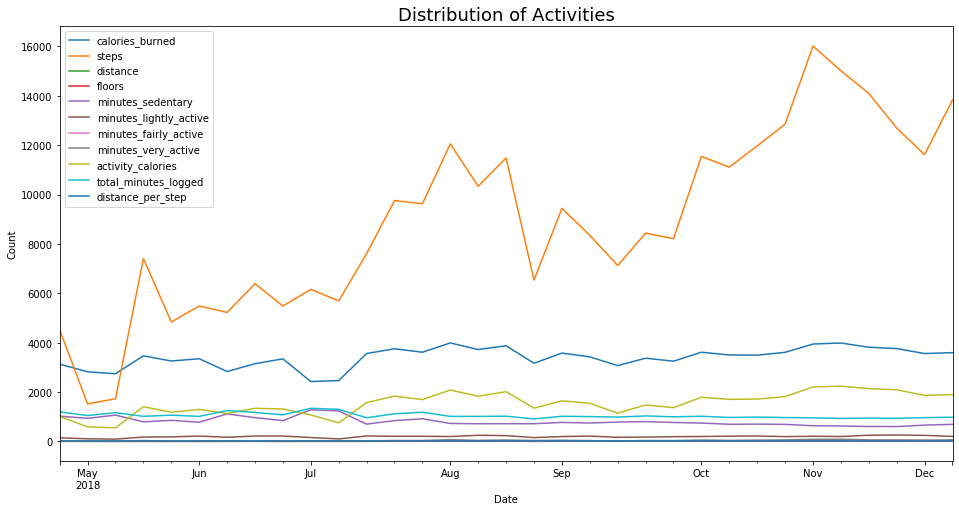

In [92]:
# We will get a general idea of shape of our data by week
fig = df.resample("W").mean().plot(figsize=(16,8))
plt.xlabel("Date")
plt.ylabel("Count")
plt.title("Distribution of Activities", fontsize=18)

In [20]:
# move?
df.sort_index().steps.sort_values(ascending=True).head(15)

date
2018-06-27      0
2018-07-04      0
2018-07-03      0
2018-06-30      0
2018-06-06      0
2018-06-07      0
2018-06-29      0
2018-06-11      0
2018-06-28      0
2018-07-05      0
2018-07-06      0
2018-06-26      0
2018-05-09     21
2018-08-24     68
2018-07-02    172
Name: steps, dtype: int64

### *Calories Burned*

Text(0.5, 1.0, 'Distribution of Calories Burned')

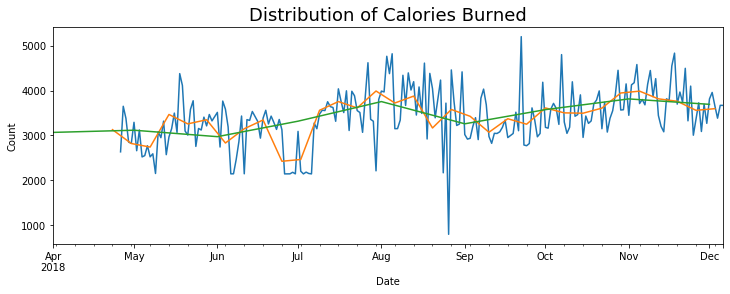

In [93]:
# Look at the difference between day, week and month
df['calories_burned'].resample("D").mean().plot(figsize=(12,4))
df['calories_burned'].resample("W").mean().plot(figsize=(12,4))
df['calories_burned'].resample("M").mean().plot(figsize=(12,4))
plt.xlabel("Date")
plt.ylabel("Count")
plt.title("Distribution of Calories Burned", fontsize=18)

Text(0.5, 1.0, 'Rolling Average of Calories Burned During One Week')

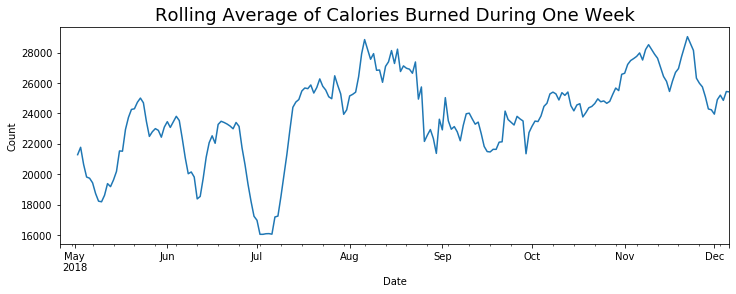

In [94]:
# Look at rolling averages of one week and two weeks
df['calories_burned'].rolling(7).sum().plot(figsize=(12,4))
plt.xlabel("Date")
plt.ylabel("Count")
plt.title("Rolling Average of Calories Burned During One Week", fontsize=18)

Text(0.5, 1.0, 'Rolling Average of Calories Burned During Two Weeks')

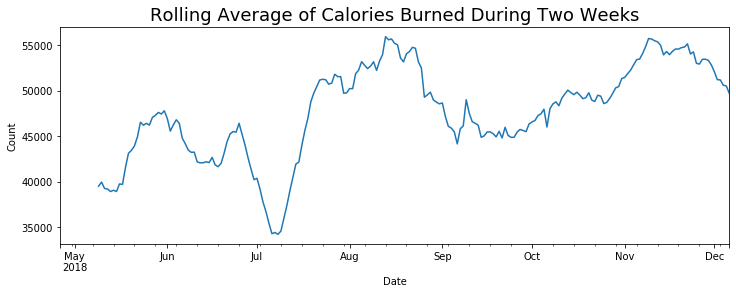

In [95]:
df['calories_burned'].rolling(14).sum().plot(figsize=(12,4))
plt.xlabel("Date")
plt.ylabel("Count")
plt.title("Rolling Average of Calories Burned During Two Weeks", fontsize=18)

Text(0.5, 1.0, 'Day to Day Difference of Calories Burned')

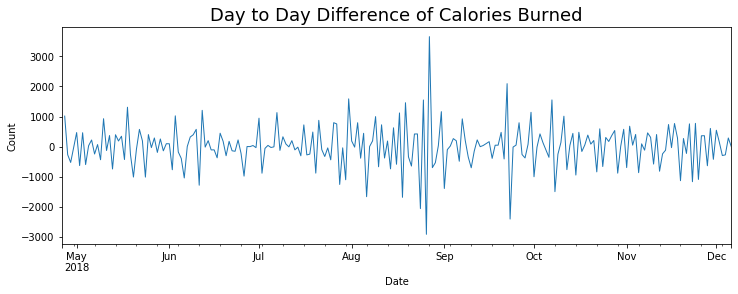

In [96]:
# Look at the difference from day to day
df['calories_burned'].resample("D").mean().diff().plot(figsize=(12,4), linewidth=1)
plt.xlabel("Date")
plt.ylabel("Count")
plt.title("Day to Day Difference of Calories Burned", fontsize=18)

**Takeaway:** There is a large spike at the end of August and a slightly smaller spike at the end of September.

Task: Narrow in on the end of those months to pinpoint the anomalies.

Text(0.5, 1.0, 'Are There Outliers for Individual Weekdays?')

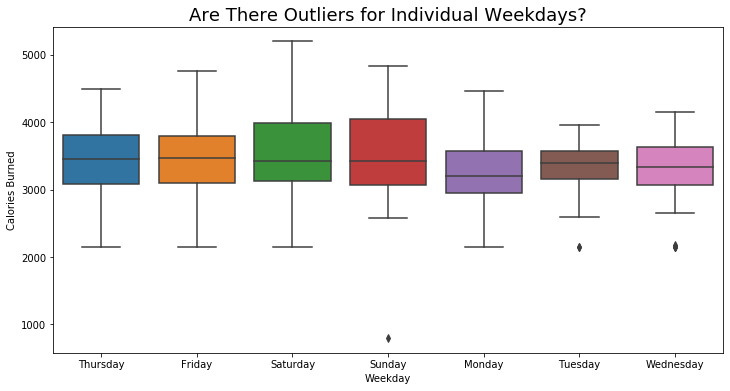

In [101]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x='weekday', y='calories_burned')
plt.xlabel("Weekday")
plt.ylabel("Calories Burned")
plt.title("Are There Outliers for Individual Weekdays?", fontsize=18)

There are a few outliers on Sundays/Tuesdays/Wednesdays in particular.

Text(0.5, 1.0, 'Are There Outliers in Individual Months?')

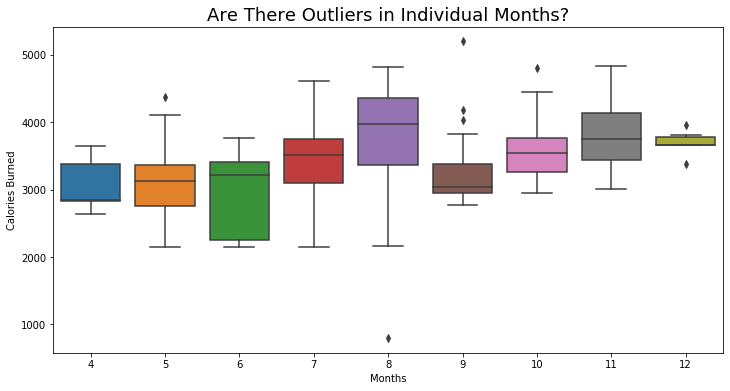

In [100]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x='month', y='calories_burned')
plt.xlabel("Months")
plt.ylabel("Calories Burned")
plt.title("Are There Outliers in Individual Months?", fontsize=18)

Four out of the nine months of data have outliers in them. Mostly higher outliers.

**Takeaway:** Our wearer burned more calories during the end of the week.

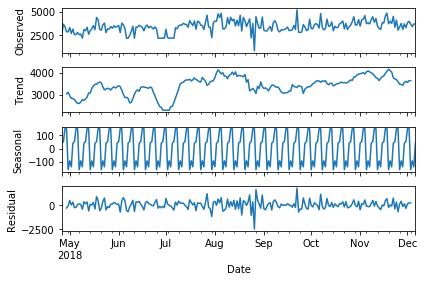

In [103]:
decomp = sm.tsa.seasonal_decompose(df['calories_burned'].resample("D").mean(), model='additive')
fig = decomp.plot()
plt.xlabel("Date")
plt.show()

**Takeaway:** There is no definitive trend for calories burned. Can eyeball that there is a slight increase throughout the data.

### *Steps*

Text(0.5, 1.0, 'Average Steps')

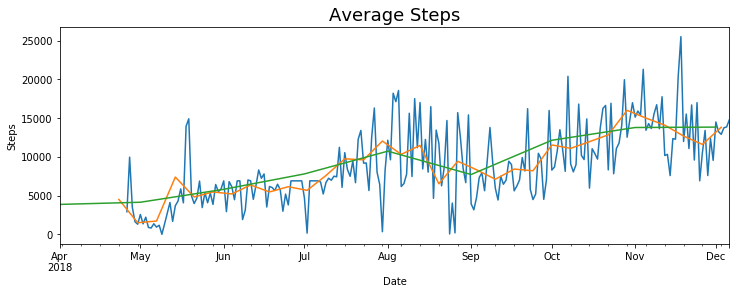

In [105]:
# Look at day, week and month together to see shape of steps feature.
df['steps'].resample("D").mean().plot(figsize=(12,4))
df['steps'].resample("W").mean().plot(figsize=(12,4))
df['steps'].resample("M").mean().plot(figsize=(12,4))
plt.xlabel("Date")
plt.ylabel("Steps")
plt.title("Average Steps", fontsize=18)

Text(0.5, 1.0, 'Average Steps a Week')

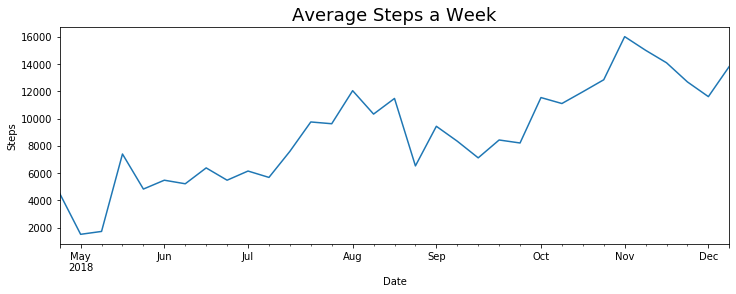

In [106]:
# In general, there is a positive trend occuring for steps.
df['steps'].resample("W").mean().plot(figsize=(12,4))
plt.xlabel("Date")
plt.ylabel("Steps")
plt.title("Average Steps a Week", fontsize=18)

Text(0.5, 1.0, 'Average Steps a Week')

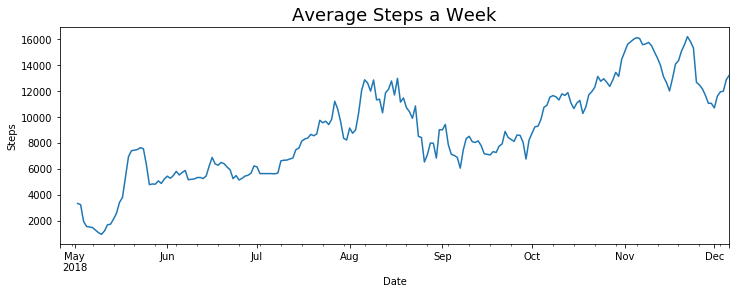

In [107]:
# Look at the rolling averages of steps from one week to two weeks. Smooth out the data
df['steps'].rolling(7).mean().plot(figsize=(12,4))
plt.xlabel("Date")
plt.ylabel("Steps")
plt.title("Average Steps a Week", fontsize=18)

Text(0.5, 1.0, 'Average Steps Every Two Weeks')

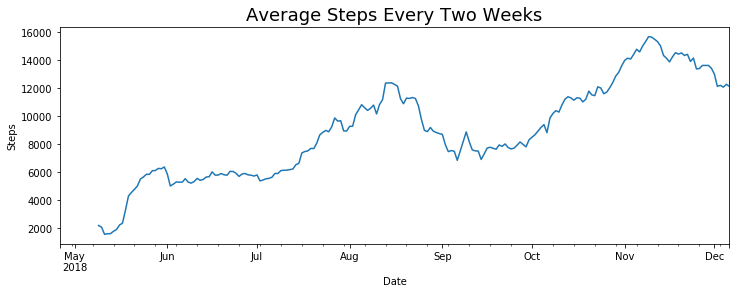

In [108]:
df['steps'].rolling(14).mean().plot(figsize=(12,4))
plt.xlabel("Date")
plt.ylabel("Steps")
plt.title("Average Steps Every Two Weeks", fontsize=18)

Text(0.5, 1.0, 'Daily Differences in Steps')

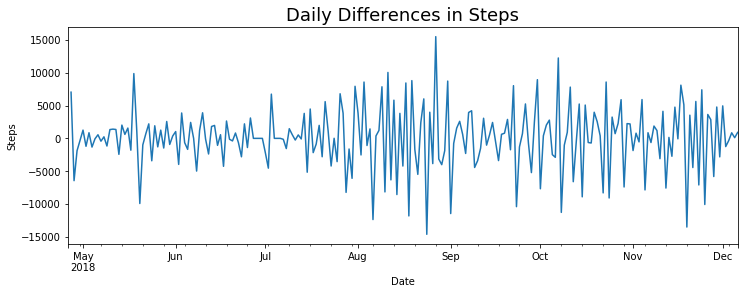

In [109]:
# Look at the differences from day to day. There are larger difference the longer the wearer has the fitbit
df['steps'].resample("D").mean().diff().plot(figsize=(12,4))
plt.xlabel("Date")
plt.ylabel("Steps")
plt.title("Daily Differences in Steps", fontsize=18)

Text(0.5, 1.0, 'Are there any trends in number of steps a week?')

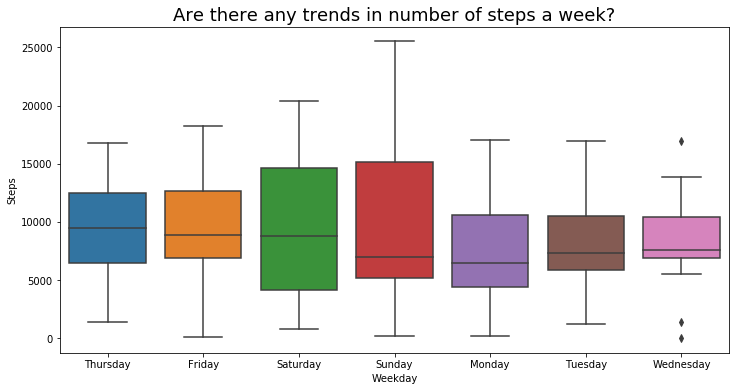

In [111]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x='weekday', y='steps')
plt.xlabel("Weekday")
plt.ylabel("Steps")
plt.title("Are there any trends in number of steps a week?", fontsize=18)

Text(0.5, 1.0, 'Are there any trends in number of steps a month?')

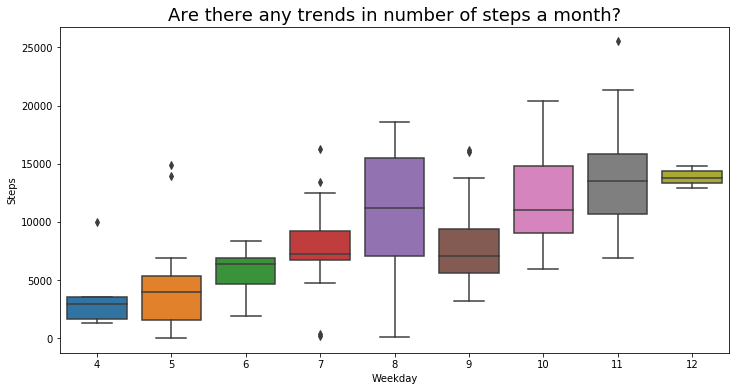

In [112]:
# outliers
# august 
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x='month', y='steps')
plt.xlabel("Weekday")
plt.ylabel("Steps")
plt.title("Are there any trends in number of steps a month?", fontsize=18)

**Takeaway:** The wearer takes more steps during the weekends, probably sits a lot for work during the weekdays. The steps also generally increase each month, apart from our unfinished months, April and December.

In [36]:
# Look at average steps during each month in descending order to match up to the visual.
df1.sort_values(by='steps', ascending=False)

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,total_minutes_logged,distance_per_step
date,,,,,,,,,,,
2018-12-31,3692.166667,13847.333333,6.598333,40.333333,671.333333,219.000000,17.000000,67.000000,2002.500000,974.333333,0.000476
2018-11-30,3813.066667,13794.800000,6.620333,24.500000,620.500000,236.900000,19.133333,66.633333,2111.433333,943.166667,0.000480
2018-10-31,3574.451613,12149.387097,5.740000,23.032258,705.161290,205.645161,19.032258,54.903226,1779.903226,984.741935,0.000472
2018-08-31,3753.612903,10743.967742,5.075161,12.451613,717.354839,216.419355,13.580645,51.677419,1901.935484,999.032258,0.000472
2018-09-30,3258.833333,7732.100000,3.655000,13.633333,779.100000,185.600000,13.266667,26.733333,1346.866667,1004.700000,0.000472
2018-07-31,3317.290323,6916.741935,3.263871,5.935484,920.000000,171.580645,17.483871,22.483871,1331.903226,1131.548387,0.000472
2018-05-31,3116.032258,4156.032258,1.960000,1.387097,908.483871,151.709677,11.677419,8.225806,984.967742,1080.096774,0.000472
2018-06-30,2972.600000,3980.533333,1.878000,3.233333,1012.233333,152.166667,10.000000,4.466667,923.833333,1178.866667,0.000472
2018-04-30,3067.800000,3877.000000,1.826000,4.600000,995.600000,138.600000,13.600000,5.600000,916.800000,1153.400000,0.000470


**Takeaway:** Even though December is unfinished, it has the highest mean. The wearer is getting more and more active each month.

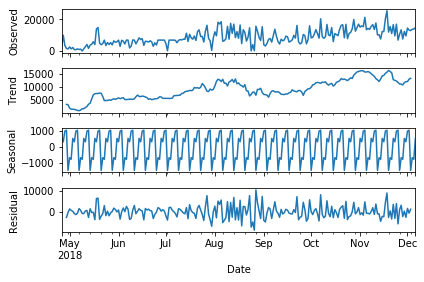

In [114]:
decomp = sm.tsa.seasonal_decompose(df['steps'].resample("D").mean(), model='additive')
fig = decomp.plot()
plt.xlabel("Date")
plt.show()

- Trend is similar to calories burned
- There is a lot of residual noise for steps

In [38]:
# Create new df to sort by month, then look at the anomalies for the month of May
df_mo = df.resample("D").mean()
d = df_mo.sort_values(by='month')
d[d.month == 5].sort_values(by='steps')

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,total_minutes_logged,distance_per_step,month
date,,,,,,,,,,,,
2018-05-09,2153,21,0.01,0,1438,2,0,0,8,1440,0.000476,5
2018-05-05,2551,833,0.39,0,969,68,0,0,326,1037,0.000468,5
2018-05-04,2522,904,0.43,1,1012,61,0,0,269,1073,0.000476,5
2018-05-07,2524,952,0.45,0,907,63,0,0,283,970,0.000473,5
2018-05-08,2591,1187,0.56,2,1221,53,17,2,410,1293,0.000472,5
2018-05-10,3081,1364,0.64,0,1295,136,5,4,924,1440,0.000469,5
2018-05-02,2660,1372,0.65,0,927,90,0,0,419,1017,0.000474,5
2018-05-06,2771,1383,0.65,0,976,103,0,0,506,1079,0.000470,5
2018-05-13,2572,1689,0.80,0,895,84,0,0,394,979,0.000474,5


**Takeaway:** 05/09/2018 only took 21 steps and 05/18-19 had significantly more steps than average.

**Task:** Decide how to fill the missing values

In [39]:
# Look at April keeping in mind this is an incomplete month
# April has a wide range of steps with 04/27/2018 higher than average
d[d.month == 4].sort_values(by='steps')

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,total_minutes_logged,distance_per_step,month
date,,,,,,,,,,,,
2018-04-30,2825,1323,0.62,0,880,104,0,0,540,984,0.000469,4
2018-04-29,2851,1639,0.77,0,891,122,0,0,602,1013,0.000470,4
2018-04-26,2635,2931,1.38,2,1347,93,0,0,566,1440,0.000471,4
2018-04-28,3379,3521,1.66,2,702,155,22,11,1124,890,0.000471,4
2018-04-27,3649,9971,4.70,19,1158,219,46,17,1752,1440,0.000471,4


In [40]:
d[d.month == 7].sort_values(by='steps').tail(10)

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,total_minutes_logged,distance_per_step,month
date,,,,,,,,,,,,
2018-07-17,3760,8377,3.95,12,646,258,8,25,1803,937,0.000472,7
2018-07-23,3553,9203,4.34,5,748,204,23,31,1597,1006,0.000472,7
2018-07-24,3510,9215,4.35,6,1203,193,15,29,1551,1440,0.000472,7
2018-07-19,3993,9484,4.47,4,1116,243,57,24,2093,1440,0.000471,7
2018-07-16,4037,10551,4.98,4,714,204,51,47,2084,1016,0.000472,7
2018-07-14,3622,11239,5.30,10,709,203,39,35,1770,986,0.000472,7
2018-07-21,3983,12279,5.79,10,569,184,37,83,2162,873,0.000472,7
2018-07-26,3864,12467,5.88,10,704,214,11,58,1962,987,0.000472,7
2018-07-22,3883,13418,6.33,19,839,210,16,69,2015,1134,0.000472,7


**Takeaway:** July has missing values in the beginning of the month, around the holiday and he end of July has higher than average steps.

**Task:** Decide how to fill the missing values.

In [41]:
d[d.month == 9].sort_values(by='steps').tail()

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,total_minutes_logged,distance_per_step,month
date,,,,,,,,,,,,
2018-09-20,3517,9920,4.68,8,844,156,10,56,1565,1066,0.000472,9
2018-09-26,3613,10466,4.94,9,707,163,3,63,1677,936,0.000472,9
2018-09-08,4031,13798,6.65,16,634,237,16,76,2230,963,0.000482,9
2018-09-30,4184,15991,7.54,9,652,254,45,72,2504,1023,0.000472,9
2018-09-22,5199,16219,7.65,10,581,319,78,98,3596,1076,0.000472,9


**Takeaway:** September values are higher towards the end of the month.


In [42]:
d[d.month == 11].sort_values(by='steps')

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,total_minutes_logged,distance_per_step,month
date,,,,,,,,,,,,
2018-11-25,3005,6921,3.26,11,614,281,3,6,1306,904,0.000471,11
2018-11-14,3081,7598,3.58,15,835,214,8,12,1250,1069,0.000471,11
2018-11-28,3088,7602,3.59,16,717,272,0,0,1361,989,0.000472,11
2018-11-30,3269,9559,4.51,14,699,288,12,6,1577,1005,0.000472,11
2018-11-23,3325,9602,4.53,16,660,269,23,12,1619,964,0.000472,11
2018-11-12,3444,10184,4.82,19,651,244,14,40,1705,949,0.000473,11
2018-11-13,3202,10330,4.87,16,615,199,10,26,1376,850,0.000471,11
2018-11-26,3364,10563,5.64,20,587,210,10,42,1605,849,0.000534,11
2018-11-21,3738,11079,5.16,4,582,328,9,33,2101,952,0.000466,11


**Takeaway:** In general, November very active month for steps taken, ranging from 6921 - 25512 steps a day. Fitness is increasing.

**Task:** Fill missing values with the average steps taken from either June or July, where there are missing values.

### Distance

Text(0.5, 1.0, 'Distance Walked Each Day')

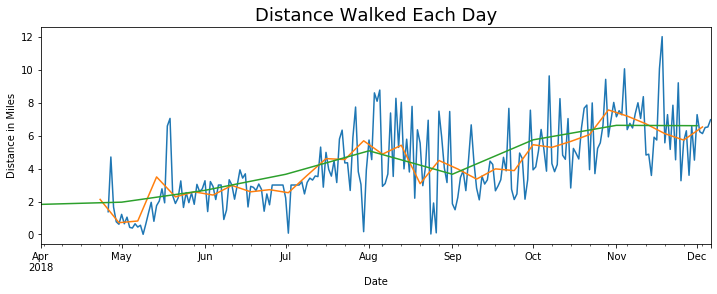

In [116]:
# Look at distance to see shape by day, week and month
df.distance.resample("D").mean().plot(figsize=(12,4))
df.distance.resample("W").mean().plot(figsize=(12,4))
df.distance.resample("M").mean().plot(figsize=(12,4))
plt.xlabel("Date")
plt.ylabel("Distance in Miles")
plt.title("Distance Walked Each Day", fontsize=18)

Text(0.5, 1.0, 'Moving Average a Week')

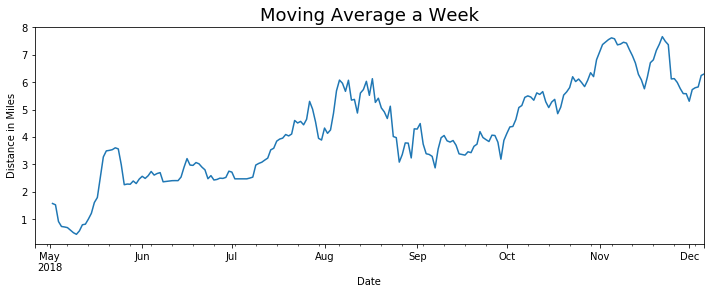

In [118]:
# Look at rolling averages for one week and two weeks
df.distance.rolling(7).mean().plot(figsize=(12,4))
plt.xlabel("Date")
plt.ylabel("Distance in Miles")
plt.title("Moving Average a Week", fontsize=18)

Text(0.5, 1.0, 'Moving Average Every Two Weeks')

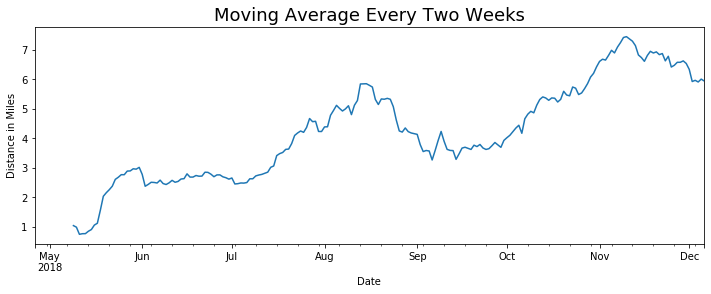

In [120]:
df.distance.rolling(14).mean().plot(figsize=(12,4))
plt.xlabel("Date")
plt.ylabel("Distance in Miles")
plt.title("Moving Average Every Two Weeks", fontsize=18)

Text(0.5, 1.0, 'Are there any trends in distance a month?')

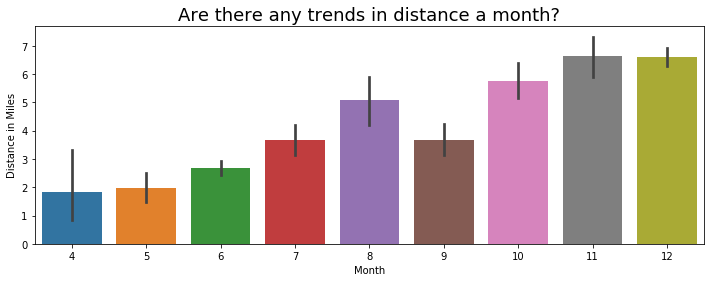

In [121]:
# Look at trends of distance per month and per week
plt.figure(figsize=(12,4))
sns.barplot(data=df, x='month', y='distance')
plt.xlabel("Month")
plt.ylabel("Distance in Miles")
plt.title("Are there any trends in distance a month?", fontsize=18)

Text(0.5, 1.0, 'Are there any trends in distance a week?')

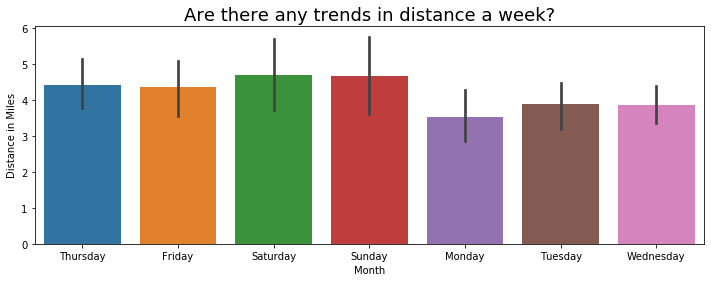

In [122]:
plt.figure(figsize=(12,4))
sns.barplot(data=df, x='weekday', y='distance')
plt.xlabel("Month")
plt.ylabel("Distance in Miles")
plt.title("Are there any trends in distance a week?", fontsize=18)

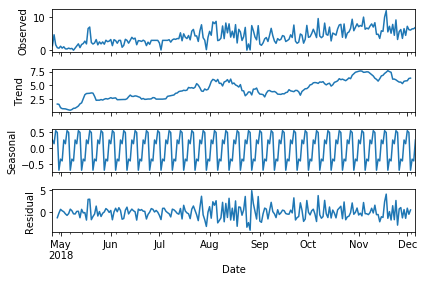

In [123]:
decomp = sm.tsa.seasonal_decompose(df['distance'].resample("D").mean(), model='additive')
fig = decomp.plot()
plt.xlabel("Date")
plt.show()

**Takeaway:** As expected, the trend is still the same as with the other features in the data.

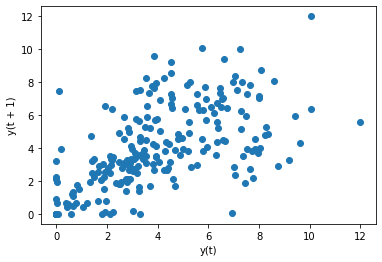

In [49]:
# Look at the lag time for days compared to weeks
pd.plotting.lag_plot(df.distance.resample('D').mean(), lag=1)

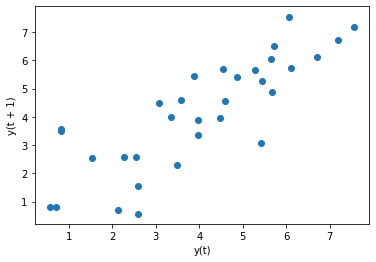

In [50]:
pd.plotting.lag_plot(df.distance.resample('W').mean(), lag=1)

**Takeaway:** The correlation shown the clearest when resampled by week.

### Distance per step

Text(0.5, 1.0, 'Are there any anomalies in distance per step?')

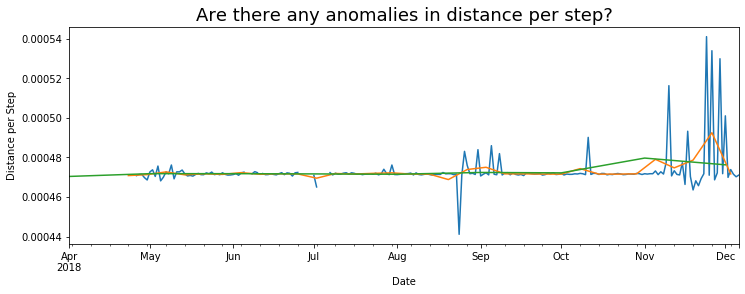

In [127]:
# Look at distance per steps
df['distance_per_step'].resample("D").mean().plot(figsize=(12,4))
df['distance_per_step'].resample("W").mean().plot(figsize=(12,4))
df['distance_per_step'].resample("M").mean().plot(figsize=(12,4))
plt.xlabel("Date")
plt.ylabel("Distance per Step")
plt.title("Are there any anomalies in distance per step?", fontsize=18)

Text(0.5, 1.0, 'Daily Distance per Step')

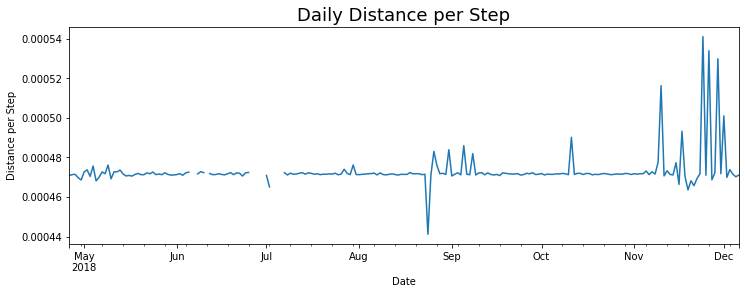

In [126]:
df['distance_per_step'].resample("D").mean().plot(figsize=(12,4))
plt.xlabel("Date")
plt.ylabel("Distance per Step")
plt.title("Daily Distance per Step", fontsize=18)

Text(0.5, 1.0, 'Weekly Distance per Step')

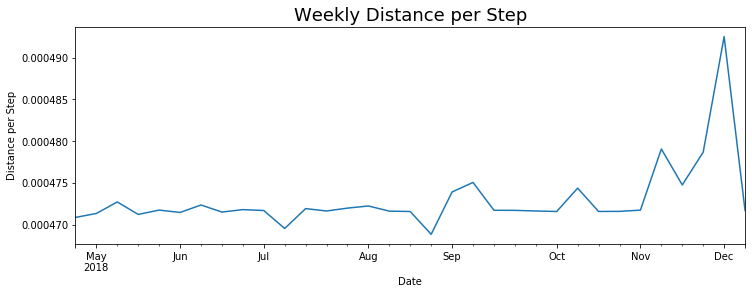

In [129]:
df['distance_per_step'].resample("W").mean().plot(figsize=(12,4))
plt.xlabel("Date")
plt.ylabel("Distance per Step")
plt.title("Weekly Distance per Step", fontsize=18)

Text(0.5, 1.0, 'Daily Difference in Distance per Step')

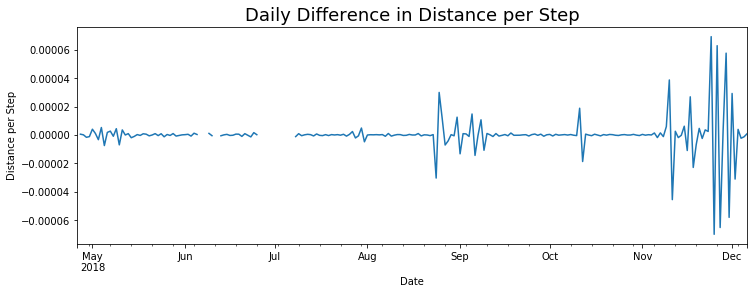

In [130]:
df['distance_per_step'].resample("D").mean().diff().plot(figsize=(12,4))
plt.xlabel("Date")
plt.ylabel("Distance per Step")
plt.title("Daily Difference in Distance per Step", fontsize=18)

**Takeaway:** The steps greatly increase towards the end of the data, with a quick influx near September. There is a gap around July, the missing values seen before, the wearer probably not wearing the fitbit.

Text(0.5, 1.0, 'Monthly Distance per Step')

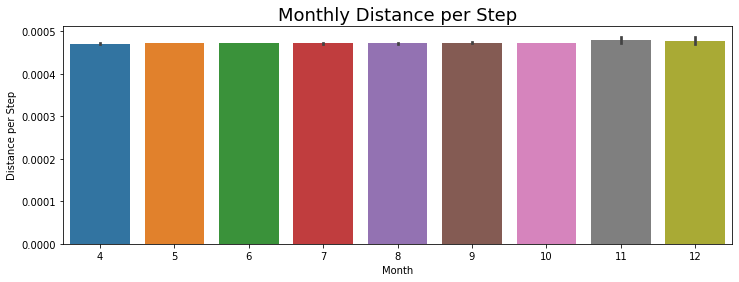

In [131]:
# Average strides will be the same, move on from here
plt.figure(figsize=(12,4))
sns.barplot(data=df, x='month', y='distance_per_step')
plt.xlabel("Month")
plt.ylabel("Distance per Step")
plt.title("Monthly Distance per Step", fontsize=18)

Text(0.5, 1.0, 'Weekly Distance per Step')

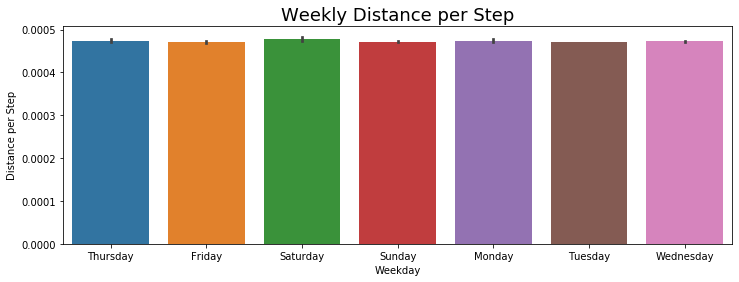

In [132]:
plt.figure(figsize=(12,4))
sns.barplot(data=df, x='weekday', y='distance_per_step')
plt.xlabel("Weekday")
plt.ylabel("Distance per Step")
plt.title("Weekly Distance per Step", fontsize=18)

### Floors

Text(0.5, 1.0, 'Average Number of Floors a Week')

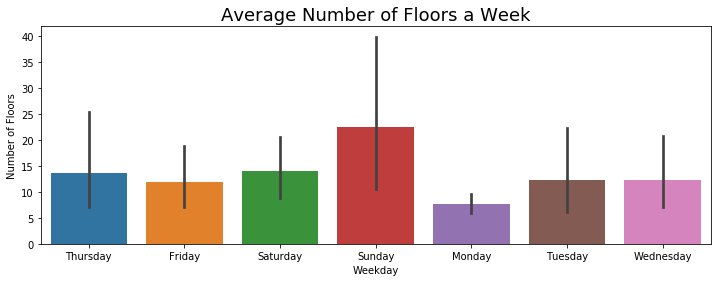

In [133]:
plt.figure(figsize=(12,4))
sns.barplot(data=df, x='weekday', y='floors')
plt.xlabel("Weekday")
plt.ylabel("Number of Floors")
plt.title("Average Number of Floors a Week", fontsize=18)

Text(0.5, 1.0, 'Average Number of Floors a Month')

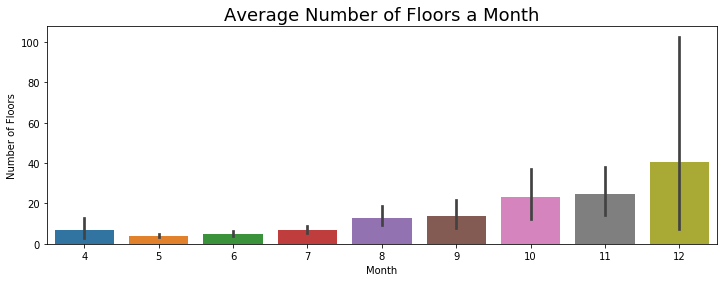

In [134]:
plt.figure(figsize=(12,4))
sns.barplot(data=df, x='month', y='floors')
plt.xlabel("Month")
plt.ylabel("Number of Floors")
plt.title("Average Number of Floors a Month", fontsize=18)

**Takeaway:** You can see how the activity level is increasing throughout the months of data that we have.

In [59]:
# Look at missing values in activity calories
df.activity_calories.value_counts().head()

0       9
1125    2
1684    2
1427    2
1630    2
Name: activity_calories, dtype: int64

### Total minutes logged

In [60]:
df.total_minutes_logged.sort_values().head(15)

date
2018-08-26     41
2018-08-18    749
2018-11-02    816
2018-06-03    817
2018-08-11    822
2018-11-07    824
2018-05-28    832
2018-11-19    834
2018-09-16    838
2018-11-26    849
2018-12-01    849
2018-11-13    850
2018-11-24    862
2018-05-22    869
2018-07-12    870
Name: total_minutes_logged, dtype: int64

In [61]:
# Look at totals grouped by weekdays
weekday_totals = df.groupby(df.index.weekday).sum()

Text(0.5, 1.0, 'Weekly Totals')

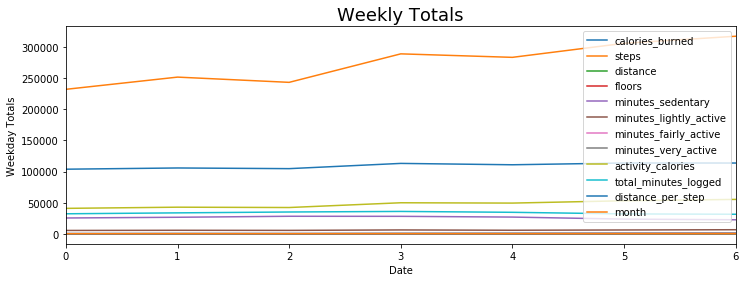

In [135]:
weekday_totals.plot(figsize=(12, 4))
plt.xlabel("Date")
plt.ylabel("Weekday Totals")
plt.title("Weekly Totals", fontsize=18)

In [63]:
df = df.resample('D').mean()

### Minutes Sedentary

Text(0.5, 1.0, 'Average Sedentary Minutes by Day')

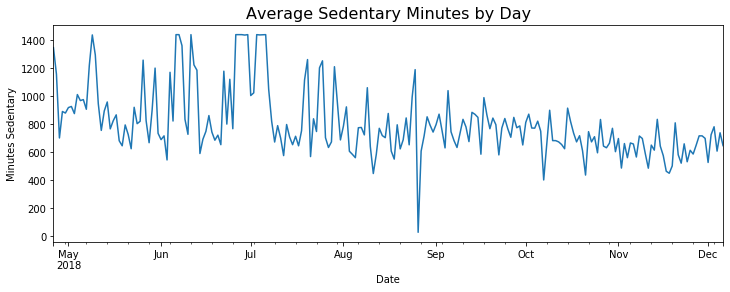

In [138]:
fig_1 = df['minutes_sedentary'].plot(figsize= (12,4))
plt.xlabel("Date")
plt.ylabel("Minutes Sedentary")
fig_1.set_title('Average Sedentary Minutes by Day', fontsize=16)

Text(0.5, 1.0, 'Average Lighltly Active Minutes by Day')

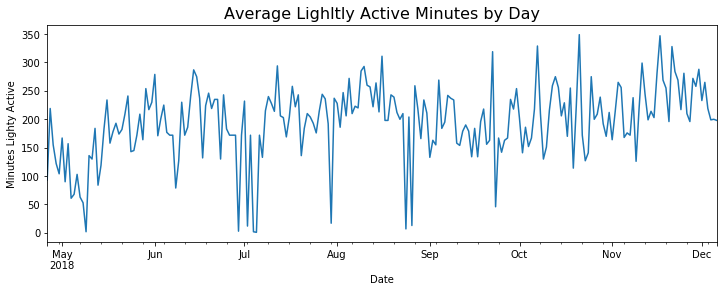

In [139]:
fig_2 = df['minutes_lightly_active'].plot(figsize= (12,4))
plt.xlabel("Date")
plt.ylabel("Minutes Lighty Active")
fig_2.set_title('Average Lighltly Active Minutes by Day', fontsize=16)

Text(0.5, 1.0, 'Average Fairly Active Minutes by Day')

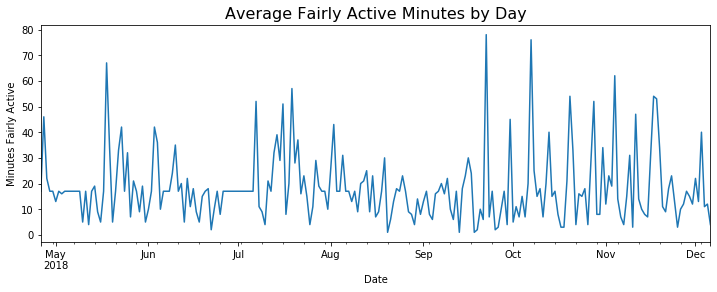

In [140]:
fig_3 = df['minutes_fairly_active'].plot(figsize= (12,4))
plt.xlabel("Date")
plt.ylabel("Minutes Fairly Active")
fig_3.set_title('Average Fairly Active Minutes by Day', fontsize=16)

Text(0.5, 1.0, 'Average Very Active Minutes by Day')

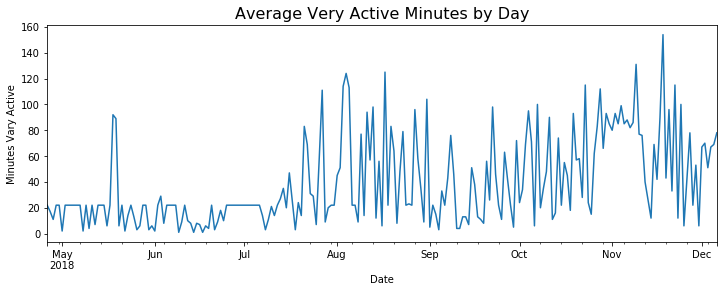

In [141]:
fig_4 = df['minutes_very_active'].plot(figsize= (12,4))
plt.xlabel("Date")
plt.ylabel("Minutes Vary Active")
fig_4.set_title('Average Very Active Minutes by Day', fontsize=16)

**Takeaway:** Thanksgiving was on Thurs Nov 22nd and it was user's 7th most active day and 5th most very active day

Text(0.5, 1.0, 'Average Minutes per Activity Level by Day')

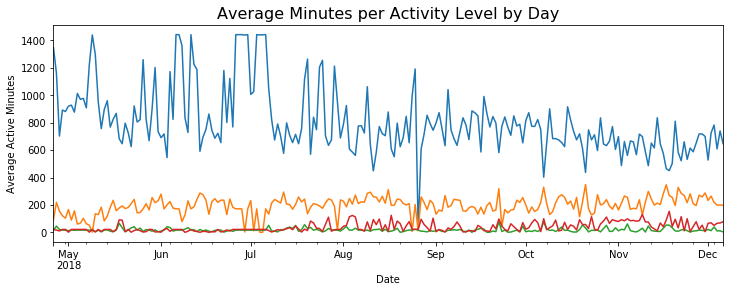

In [142]:
df = df.resample('D').mean()

fig_1 = df['minutes_sedentary'].plot(figsize= (12,4))
fig_2 = df['minutes_lightly_active'].plot(figsize= (12,4))
fig_3 = df['minutes_fairly_active'].plot(figsize= (12,4))
fig_4 = df['minutes_very_active'].plot(figsize= (12,4))
plt.xlabel("Date")
plt.ylabel("Average Active Minutes")
fig_4.set_title('Average Minutes per Activity Level by Day', fontsize=16)

**Takeaways:**
    - August 26th, user only wore fitbit for 41 mins
    - Wore fitbit all day a few times in July but never again after that

In [69]:
df = df.resample('W').mean()

Text(0.5, 1.0, 'Average Sedentary Minutes by Week')

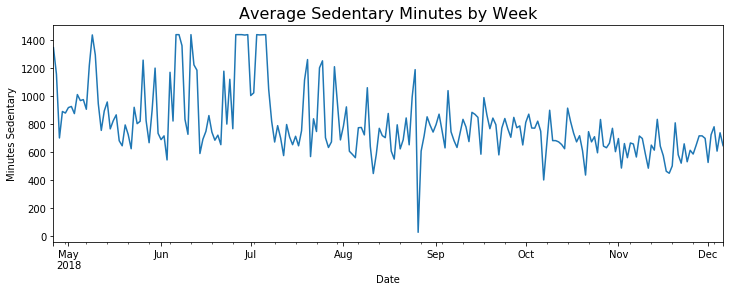

In [143]:
fig_1 = df['minutes_sedentary'].plot(figsize= (12,4))
plt.xlabel("Date")
plt.ylabel("Minutes Sedentary")
fig_1.set_title('Average Sedentary Minutes by Week', fontsize=16)

Text(0.5, 1.0, 'Average Lighltly Active Minutes by Week')

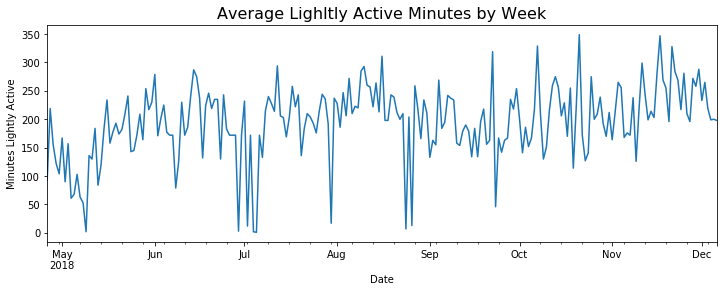

In [144]:
fig_2 = df['minutes_lightly_active'].plot(figsize= (12,4))
plt.xlabel("Date")
plt.ylabel("Minutes Lightly Active")
fig_2.set_title('Average Lighltly Active Minutes by Week', fontsize=16)

Text(0.5, 1.0, 'Average Fairly Active Minutes by Week')

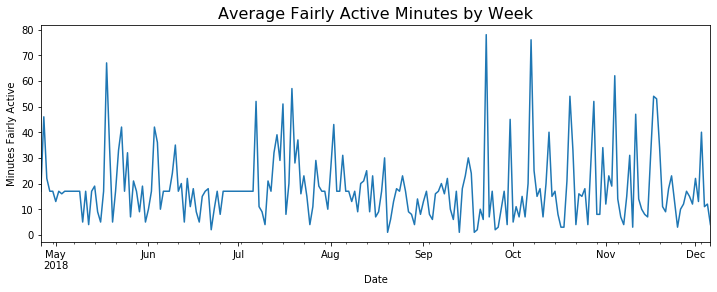

In [145]:
fig_3 = df['minutes_fairly_active'].plot(figsize= (12,4))
plt.xlabel("Date")
plt.ylabel("Minutes Fairly Active")
fig_3.set_title('Average Fairly Active Minutes by Week', fontsize=16)

Text(0.5, 1.0, 'Average Very Active Minutes by Week')

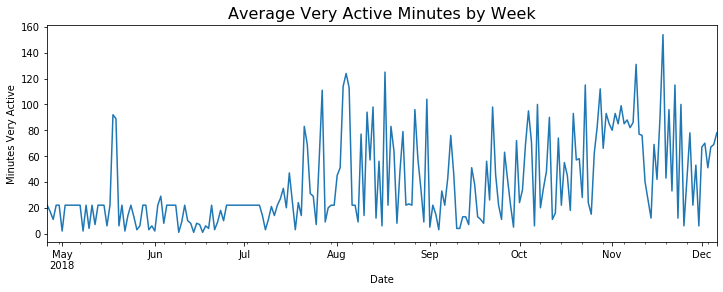

In [146]:
fig_4 = df['minutes_very_active'].plot(figsize= (12,4))
plt.xlabel("Date")
plt.ylabel("Minutes Very Active")
fig_4.set_title('Average Very Active Minutes by Week', fontsize=16)

Text(0.5, 1.0, 'Average Minutes per Activity Level by Week')

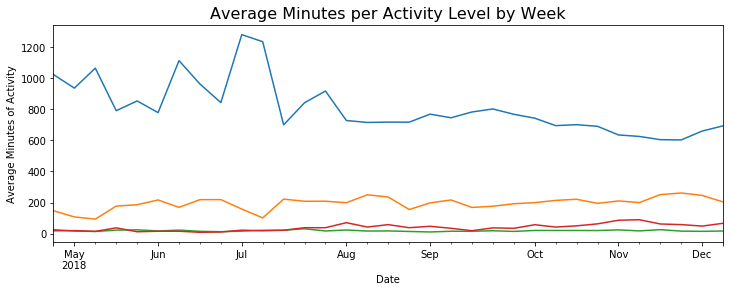

In [147]:
df = df.resample('W').mean()
fig_1 = df['minutes_sedentary'].plot(figsize= (12,4))
fig_2 = df['minutes_lightly_active'].plot(figsize= (12,4))
fig_3 = df['minutes_fairly_active'].plot(figsize= (12,4))
fig_4 = df['minutes_very_active'].plot(figsize= (12,4))
plt.xlabel("Date")
plt.ylabel("Average Minutes of Activity")
fig_4.set_title('Average Minutes per Activity Level by Week', fontsize=16)

**Takeaway:** April - July active levels have high variance including a very inactive first week of July. August through Dec is more constant. 

In [75]:
df = df.resample('M').mean()

Text(0.5, 1.0, 'Average Sedentary Minutes by Month')

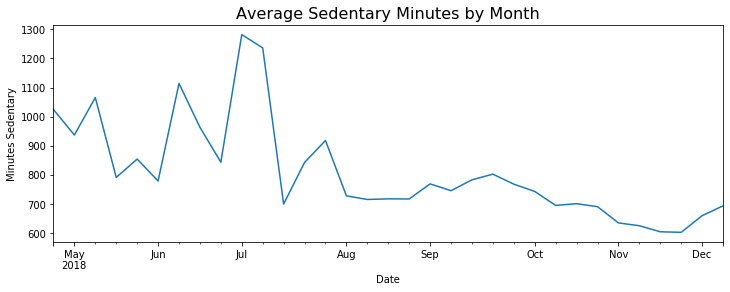

In [148]:
fig_1 = df['minutes_sedentary'].plot(figsize= (12,4))
plt.xlabel("Date")
plt.ylabel("Minutes Sedentary")
fig_1.set_title('Average Sedentary Minutes by Month', fontsize=16)

Text(0.5, 1.0, 'Average Lightly Active Minutes by Month')

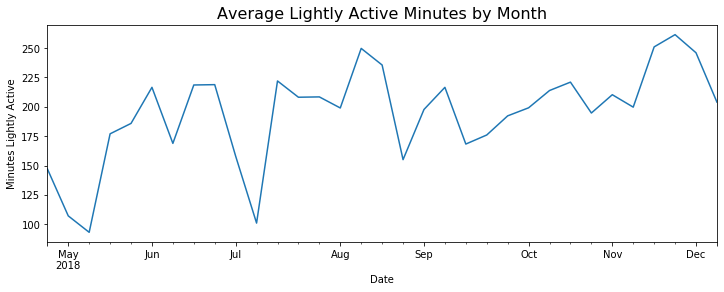

In [149]:
fig_2 = df['minutes_lightly_active'].plot(figsize= (12,4))
plt.xlabel("Date")
plt.ylabel("Minutes Lightly Active")
fig_2.set_title('Average Lightly Active Minutes by Month', fontsize=16)

Text(0.5, 1.0, 'Average Fairly Active Minutes by Month')

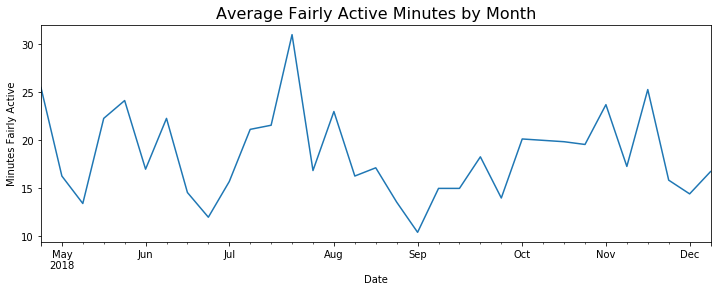

In [150]:
fig_3 = df['minutes_fairly_active'].plot(figsize= (12,4))
plt.xlabel("Date")
plt.ylabel("Minutes Fairly Active")
fig_3.set_title('Average Fairly Active Minutes by Month', fontsize=16)

Text(0.5, 1.0, 'Average Very Active Minutes by Month')

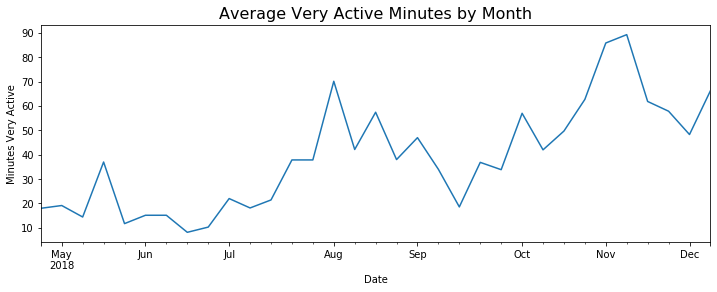

In [151]:
fig_4 = df['minutes_very_active'].plot(figsize= (12,4))
plt.xlabel("Date")
plt.ylabel("Minutes Very Active")
fig_4.set_title('Average Very Active Minutes by Month', fontsize=16)

Text(0.5, 1.0, 'Average Minutes per Activity Level by Month')

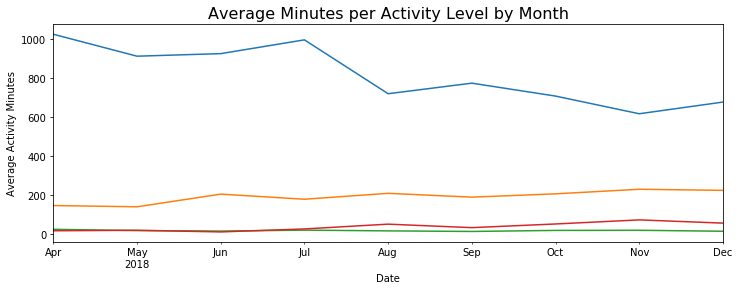

In [152]:
df = df.resample('M').mean()
fig_1 = df['minutes_sedentary'].plot(figsize= (12,4))
fig_2 = df['minutes_lightly_active'].plot(figsize= (12,4))
fig_3 = df['minutes_fairly_active'].plot(figsize= (12,4))
fig_4 = df['minutes_very_active'].plot(figsize= (12,4))
plt.xlabel("Date")
plt.ylabel("Average Activity Minutes")
fig_4.set_title('Average Minutes per Activity Level by Month', fontsize=16)

**Takeaway:** Sedentary levels go down over time. Fitbit user becomes more consistently active as time goes on. 

Text(0.5, 1.0, 'Average Very Active Minutes by Day of Week')

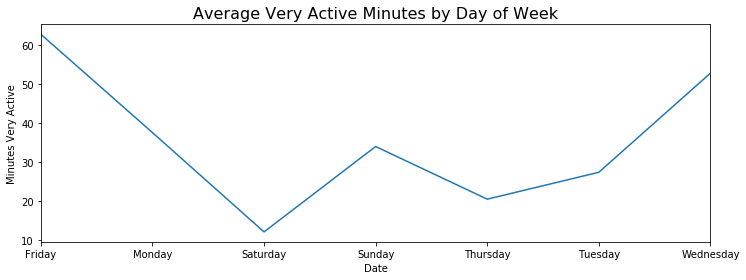

In [153]:
df = df.resample('D').mean()
daily_averages = df.groupby(df.index.weekday_name).mean()
fig_1 = daily_averages['minutes_very_active'].plot(figsize= (12,4))
plt.xlabel("Date")
plt.ylabel("Minutes Very Active")
fig_1.set_title('Average Very Active Minutes by Day of Week', fontsize=16)

Text(0.5, 1.0, 'Average Fairly Active Minutes by Day of Week')

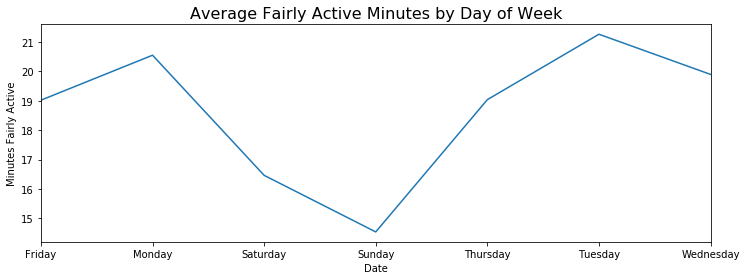

In [154]:
df = df.resample('D').mean()
daily_averages = df.groupby(df.index.weekday_name).mean()
fig_2 = daily_averages['minutes_fairly_active'].plot(figsize= (12,4))
plt.xlabel("Date")
plt.ylabel("Minutes Fairly Active")
fig_2.set_title('Average Fairly Active Minutes by Day of Week', fontsize=16)

Text(0.5, 1.0, 'Average Lightly Active Minutes by Day of Week')

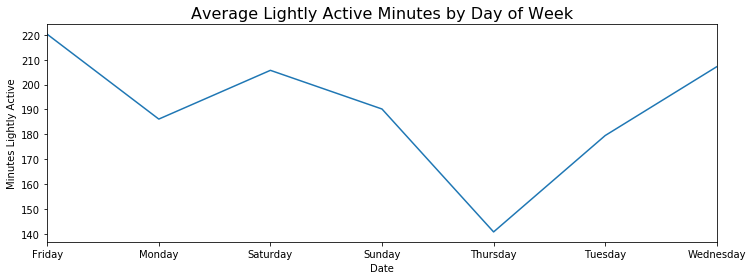

In [155]:
df = df.resample('D').mean()
daily_averages = df.groupby(df.index.weekday_name).mean()
fig_3 = daily_averages['minutes_lightly_active'].plot(figsize= (12,4))
plt.xlabel("Date")
plt.ylabel("Minutes Lightly Active")
fig_3.set_title('Average Lightly Active Minutes by Day of Week', fontsize=16)

Text(0.5, 1.0, 'Average Sedentary Minutes by Day of Week')

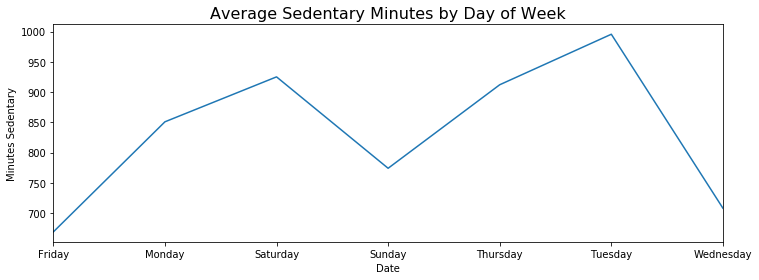

In [156]:
df = df.resample('D').mean()
daily_averages = df.groupby(df.index.weekday_name).mean()
fig_4 = daily_averages['minutes_sedentary'].plot(figsize= (12,4))
plt.xlabel("Date")
plt.ylabel("Minutes Sedentary")
fig_4.set_title('Average Sedentary Minutes by Day of Week', fontsize=16)

**Takeaway:** Fitbit user is most active on Fridays and Wednesday. They do next to nothing on Tuesday and are also very inactive on Saturdays

### Impute Missing Days
After exploring the data, we decided to take look at the mean values for each month. Since the missing values fall between June and July, we decided to take the average values from July since they are higher than June and replace any zeroes with the mean values from that month.

In [ ]:
df = acquire.acquire_data()
df = prepare.prepare_data(df)

In [86]:
df.resample("M").mean()

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,total_minutes_logged,distance_per_step
date,,,,,,,,,,,
2018-04-30,3067.800000,3877.000000,1.826000,4.600000,995.600000,138.600000,13.600000,5.600000,916.800000,1153.400000,0.000470
2018-05-31,3116.032258,4156.032258,1.960000,1.387097,908.483871,151.709677,11.677419,8.225806,984.967742,1080.096774,0.000472
2018-06-30,2972.600000,3980.533333,1.878000,3.233333,1012.233333,152.166667,10.000000,4.466667,923.833333,1178.866667,0.000472
2018-07-31,3317.290323,6916.741935,3.263871,5.935484,920.000000,171.580645,17.483871,22.483871,1331.903226,1131.548387,0.000472
2018-08-31,3753.612903,10743.967742,5.075161,12.451613,717.354839,216.419355,13.580645,51.677419,1901.935484,999.032258,0.000472
2018-09-30,3258.833333,7732.100000,3.655000,13.633333,779.100000,185.600000,13.266667,26.733333,1346.866667,1004.700000,0.000472
2018-10-31,3574.451613,12149.387097,5.740000,23.032258,705.161290,205.645161,19.032258,54.903226,1779.903226,984.741935,0.000472
2018-11-30,3813.066667,13794.800000,6.620333,24.500000,620.500000,236.900000,19.133333,66.633333,2111.433333,943.166667,0.000480
2018-12-31,3692.166667,13847.333333,6.598333,40.333333,671.333333,219.000000,17.000000,67.000000,2002.500000,974.333333,0.000476


In [87]:
df = prepare.impute_zeros(df)

In [88]:
# Checking that the zero values have been filled
df.steps.value_counts(ascending=False).head()

6916    13
6480     2
9215     1
4313     1
7806     1
Name: steps, dtype: int64

## Modeling

In [89]:
df.head(3)

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,total_minutes_logged,distance_per_step
date,,,,,,,,,,,
2018-04-26,2635,2931,1.38,2,1347,93,17,22,566,1440,0.000471
2018-04-27,3649,9971,4.70,19,1158,219,46,17,1752,1440,0.000471
2018-04-28,3379,3521,1.66,2,702,155,22,11,1124,890,0.000471


In [89]:
def split_store_data(df, train_prop=.66): 
    train_size = int(len(df) * train_prop)
    train, test = df[0:train_size], df[train_size:len(df)]
    return train, test

In [90]:
train, test = split_store_data(df, train_prop=.70)

print('Observations: %d' % (len(df)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 225
Training Observations: 157
Testing Observations: 68


In [91]:
target_vars=['steps']
df = df.resample('D')[target_vars].sum()

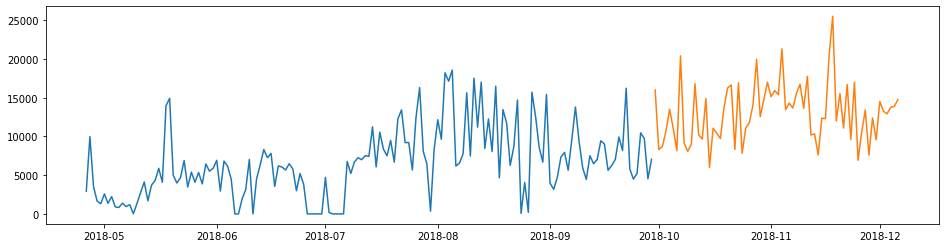

In [92]:
for var in range(len(target_vars)):
    plt.figure(figsize=(16, 4))
    plt.plot(train[target_vars[var]])
    plt.plot(test[target_vars[var]])
    plt.show()

In [93]:
def evaluate(target_var, train = train, test = test, output=True):
    mse = metrics.mean_squared_error(test[target_var], yhat[target_var])
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse

In [94]:
def plot_and_eval(target_vars, train = train, test = test, metric_fmt = '{:.2f}', linewidth = 4):
    if type(target_vars) is not list:
        target_vars = [target_vars]

    plt.figure(figsize=(16, 8))
    plt.plot(train[target_vars],label='Train', linewidth=1)
    plt.plot(test[target_vars], label='Test', linewidth=1)

    for var in target_vars:
        mse, rmse = evaluate(target_var = var, train = train, test = test, output=False)
        plt.plot(yhat[var], linewidth=linewidth)
        print(f'{var} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse))

    plt.show()

In [95]:
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'metric', 'value'])
eval_df

,model_type,target_var,metric,value


In [96]:
def append_eval_df(model_type, target_vars, train = train, test = test):
    temp_eval_df = pd.concat([pd.DataFrame([[model_type, i, 'mse', evaluate(target_var = i, 
                                                                            train = train, 
                                                                            test = test, 
                                                                            output=False)[0]],
                                            [model_type, i, 'rmse', evaluate(target_var = i, 
                                                                             train = train, 
                                                                             test = test, 
                                                                             output=False)[1]]],
                                           columns=['model_type', 'target_var', 'metric', 'value']) 
                              for i in target_vars], ignore_index=True)
    return eval_df.append(temp_eval_df, ignore_index=True)

In [97]:
yhat = pd.DataFrame(test[target_vars])
yhat.head(3)

,steps
date,
2018-09-30,15991
2018-10-01,8307
2018-10-02,8702


## Model 1: Last Observed

In [98]:
for var in target_vars:
    yhat[var] = int(train[var][-1:])

steps -- MSE: 51102765.85 RMSE: 7148.62


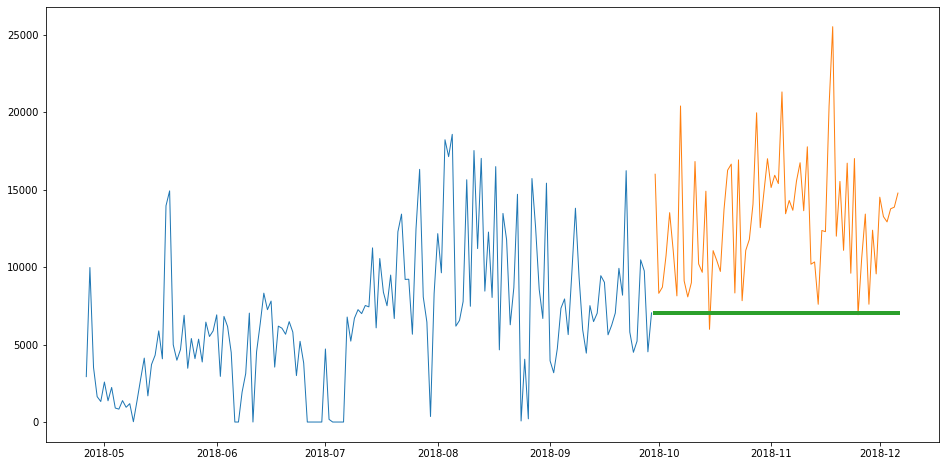

In [99]:
plot_and_eval(target_vars=target_vars, train = train, test = test)

## Model 2: Simple Average

In [100]:
for var in target_vars:
    yhat[var] = train[var].mean()

steps -- MSE: 57072047.89 RMSE: 7554.60


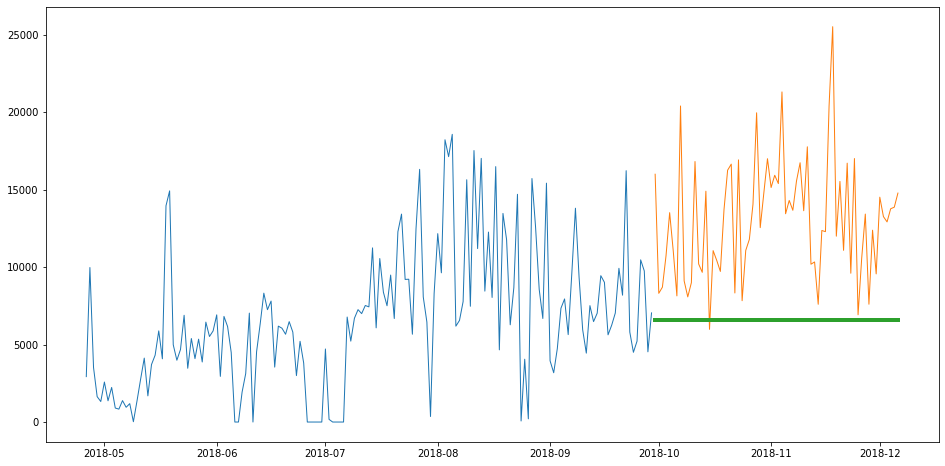

In [101]:
plot_and_eval(target_vars=target_vars, train = train, test = test)

## Model 3: Moving Average

In [102]:
periods = 14
for var in target_vars:
    yhat[var] = train[var].rolling(periods).mean().iloc[-1]

steps -- MSE: 42258628.82 RMSE: 6500.66


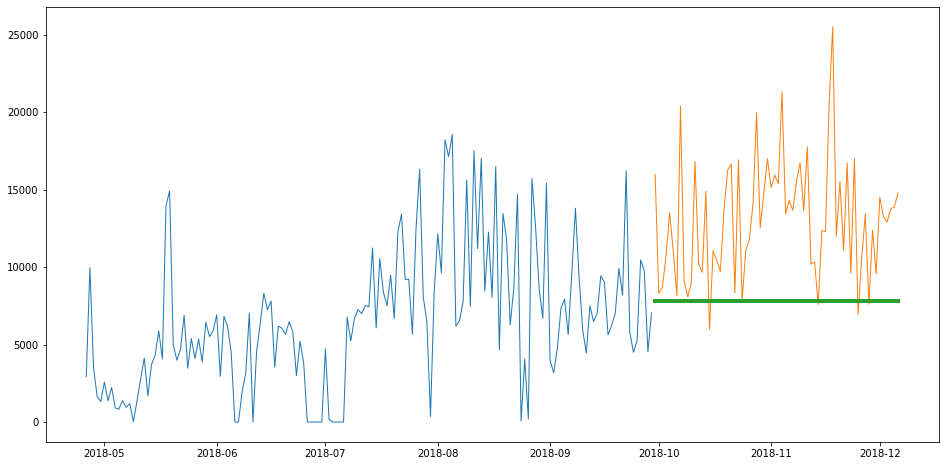

In [103]:
plot_and_eval(target_vars=target_vars, train = train, test = test)

## Model 4: Holt's Linear Trend

steps -- MSE: 85852024.23 RMSE: 9265.64


/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


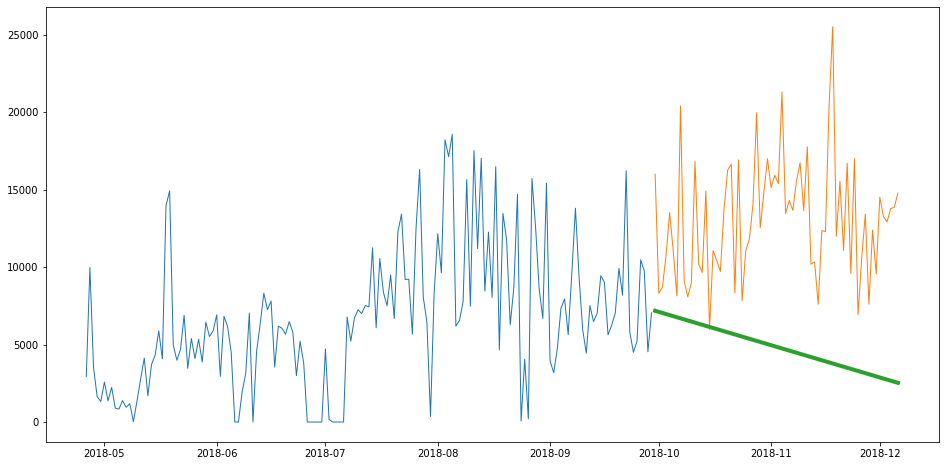

In [104]:
for var in target_vars:
    model = Holt(train[var]).fit(smoothing_level=.3, smoothing_slope=.1, optimized=False)
    yhat[var] = pd.DataFrame(model.forecast(test[var].shape[0]), columns=[var])

plot_and_eval(target_vars, train, test)
eval_df = append_eval_df(model_type='holts_linear_trend', target_vars=target_vars, train = train, test = test)

In [105]:
# to do:
# organize notebook
# data dictionary
# combine exploration
# label graphs
# read me 
# slides

# get model.py funcions to work and remove functions from notebook
# loop through moving average model to find the best one
# impute days he didn't wear fitbit

In [106]:
####TO DO:
# organize notebook
# readme 
# data dictionary
# slides
    # graphs of findings
    # analysis
# fix model.py file
# create csv of predictions
####